## L2 memorization check following 
## *Extracting Training Data from Diffusion Models* - https://arxiv.org/abs/2301.13188


Local versions of the training and generated sets are required to run this notebook.

First download them from the link provided at the main project README.


In [1]:
from PIL import Image
import glob
import numpy as np
import faiss   
import os
from tqdm import tqdm

# specify data path (remember to make sure the data path is correct)
trainset_path = '../data/CIFAR10/train/'
queryset_path = '../data/GAN-images/CIFAR10/CIFAR10-iDDPM-DDIM/'
is_saving_results = False # flag to save the intermediate results
distance_savepath = 'cifar_distance/ddim_dis.pkl'

# hyperparameters
s_nn = 50             # size of nearest neighbour set
dist_threshold = 0.75  # threshold to extract memorized samples
img_size = 32         # size of the image

In [2]:
import pathlib

IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


def get_files_at_path(path):
    """Return list of all files at path of type IMAGE_EXTENSIONS"""
 
    files = sorted([file for ext in IMAGE_EXTENSIONS
                    for file in path.glob(f'*.{ext}')])

    return files


def get_local_images(path):
    image_path = pathlib.Path(path)
    print(image_path)
    files = get_files_at_path(image_path)
    labels = []
    class_idx = 0

    def get_order(file):
        filename = os.path.splitext(os.path.basename(file))[0]
        return int(filename)

    if not files:
        # Assume sub-folders for image classes
        class_dirs = sorted(image_path.glob('*'), key=get_order) # look for all subfolders in the numerical order
        files = []
        for f in class_dirs:
            files_in_path = get_files_at_path(f)
            files += files_in_path
            labels.extend([class_idx for _ in range(len(files_in_path))])
            class_idx += 1
    labels = np.array(labels, dtype=np.int32)

    return files, labels

trainset_list, trainset_labels = get_local_images(trainset_path)
queryset_list, queryset_labels = get_local_images(queryset_path)

# load all training images and flatten to (N, ndim) array
trainset_imgs = np.array([np.array(Image.open(train_img)).reshape(-1)/255.0 for train_img in trainset_list]).astype(np.float32)

# build faiss index
d = trainset_imgs.shape[-1]
index = faiss.IndexFlatL2(d)
index.add(trainset_imgs)

../data/CIFAR10/train
../data/GAN-images/CIFAR10/CIFAR10-iDDPM-DDIM


In [3]:
# query and match samples

def calibrated_l2_distance(query, train_index, trainset_imgs, s_nn):
    """
        compute calibrated l2 distance in batch
        Parameters:
            query: a list of query imgs, shape (batch_size, input_dim)
            train_index: faiss index for fast nearest neighbour search
            trainset_img: the list of training imgs, shape (trainset_size, input_dim)
            s_nn: size of the nearest neighbour set
    """
    # search for closest training samples first 
    D, I = train_index.search(query, 1)     # D shape (query_bs, s_nn)
    D = np.sqrt(D)
    # based on the extract tranining samples, finding the nearest neighbours
    closest_idx_list = I[:, 0]
    extract_trainimg_list = np.array([trainset_imgs[closest_idx] for closest_idx in closest_idx_list])
    closest_dis_list = D[:, 0]
    D_nn, I_nn = train_index.search(extract_trainimg_list, s_nn+1)
    # exclude itself
    D_nn = D_nn[:, 1:]
    D_nn = np.sqrt(D_nn)
    normed_dis_list = closest_dis_list / D_nn.mean(axis=-1)
    return normed_dis_list, closest_idx_list
    
def query_in_batch(queryset_list):
    """
    Iterate over the batches of query samples
    """
    query_nn_dict = {}
    query_num = len(queryset_list)
    bs = 50
    # for qidx, query_imgp in tqdm(enumerate(queryset_list)):
    for qidx in tqdm(range(0, query_num, bs)):
        # (bs, 3072)
        query = np.array([np.array(Image.open(query_imgp)).reshape(-1)/255.0 for query_imgp in queryset_list[qidx: qidx + bs]]).astype(np.float32)
        normed_dis_list, closest_idx_list = calibrated_l2_distance(query, index, trainset_imgs, s_nn)
        
        for normed_dis, closest_idx, query_imgp in zip(normed_dis_list, closest_idx_list, queryset_list[qidx: qidx + bs]):
            # dict[key]: (Distance, trainimg_path)
            query_nn_dict[query_imgp] = (normed_dis, trainset_list[closest_idx])
    
    return query_nn_dict

# perform query
query_nn_dict = query_in_batch(queryset_list)

# save intermediate results
if is_saving_results:
    import pickle as pkl
    with open(distance_savepath, 'wb') as handle:
        pkl.dump(query_nn_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:15<00:00,  4.59it/s]


In [4]:
# filtered the matched samples based on the threshold
matched_sample_dict = {}
for query_path in list(query_nn_dict.keys()):
    distance_tmp = query_nn_dict[query_path][0]
    trainimg_path = query_nn_dict[query_path][1]
    if  distance_tmp < dist_threshold:
        # (Distance, trainimg_path)
        matched_sample_dict[query_path] = (distance_tmp, trainimg_path)
        
# sort the matched samples by distance
sorted_filter = sorted(matched_sample_dict.items(), key=lambda item: item[1][0])

print(f"total {len(list(matched_sample_dict.keys()))} generated samples matched")

total 1516 generated samples matched


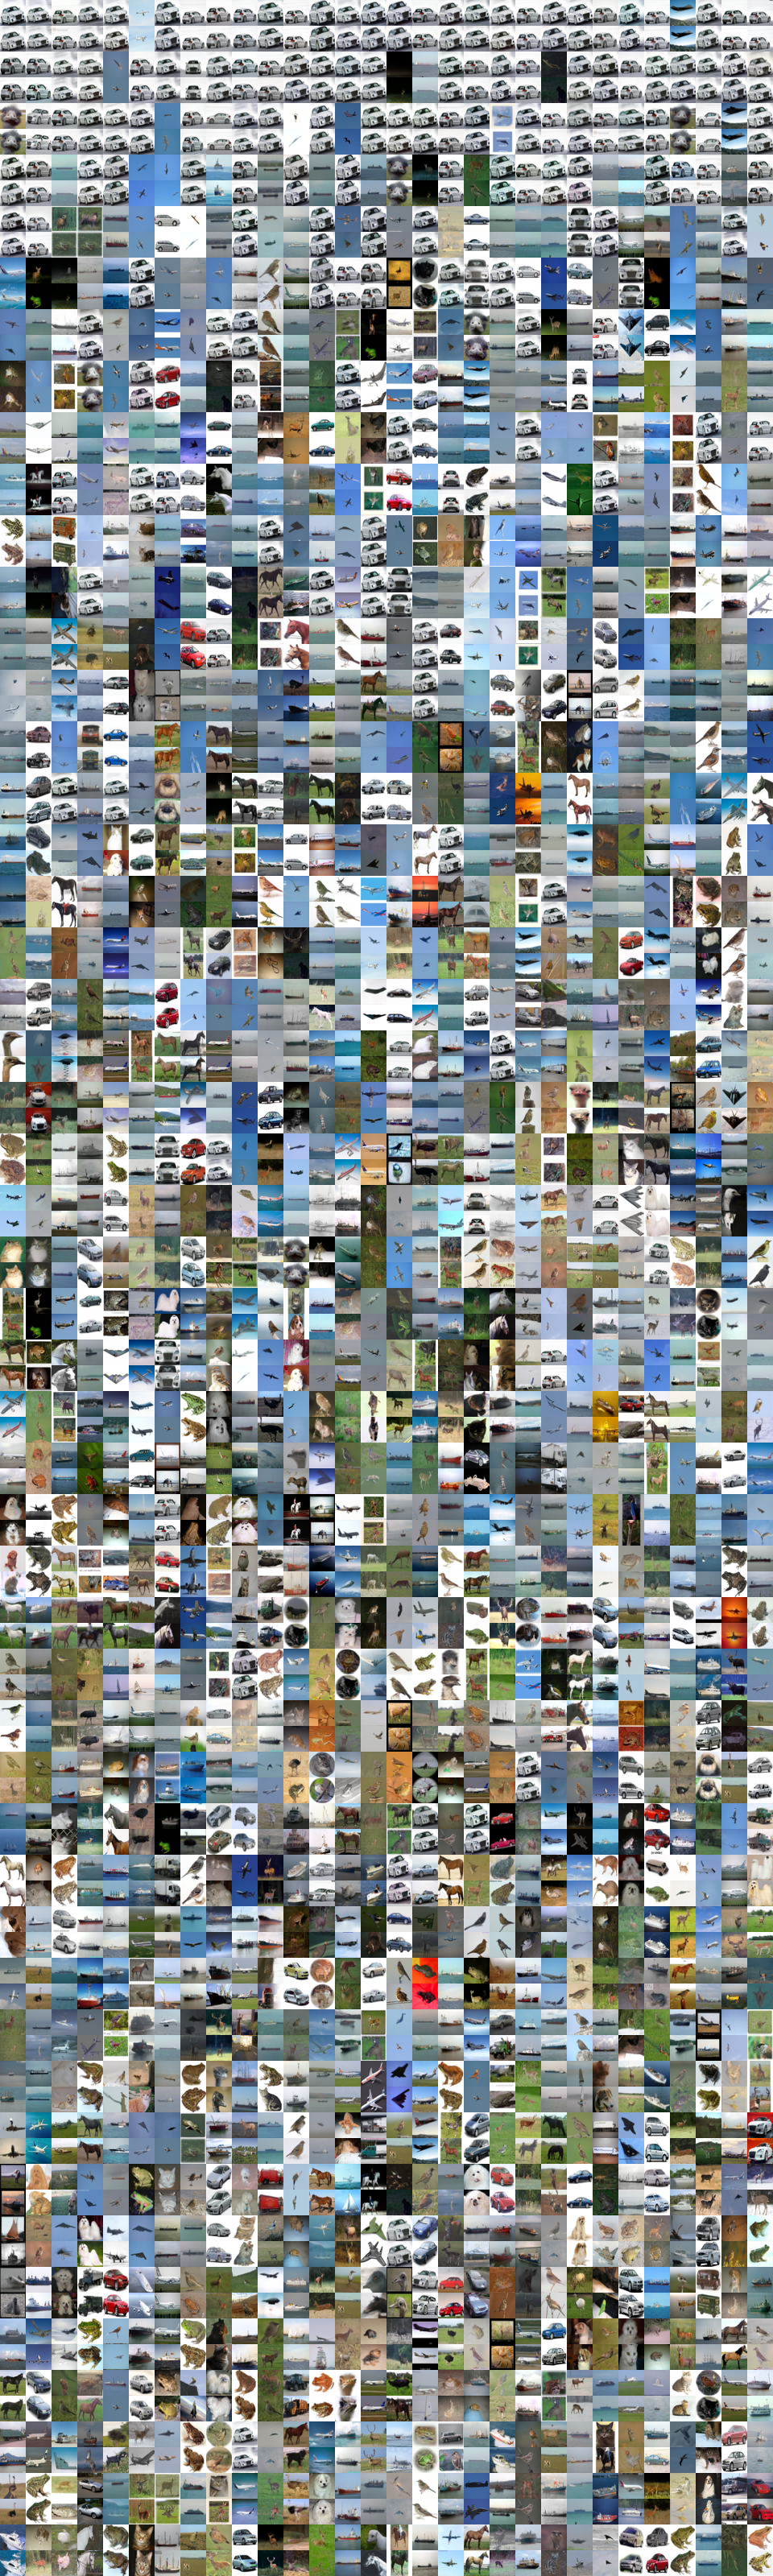

In [5]:
# show samples

def save_image_list(query_path, trainimg_path):
    final_img = np.array(Image.open(query_path))
    ref_img = np.array(Image.open(trainimg_path))
    final_img = np.concatenate((final_img, ref_img), axis=0)
    return final_img
    
query_cnt = 0
collection_img = None
row_img = None

for query_path, (distance, trainimg_path) in sorted_filter:
    paired_img = save_image_list(query_path, trainimg_path)
    query_cnt += 1
    if row_img is None:
        row_img = paired_img
    else:
        row_img = np.concatenate((row_img, paired_img), axis=1)
    if query_cnt % 30 == 0:
        if collection_img is None:
            collection_img = row_img
        else:
            collection_img = np.concatenate((collection_img, row_img), axis=0)
        row_img = None
im = Image.fromarray(np.uint8(collection_img))
display(im)